In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

plt.rcParams['figure.dpi'] = 120
sns.set(style='whitegrid')

def section(title):
    display(Markdown(f"---\n### {title}\n"))

print(" Libraries loaded successfully!")


 Libraries loaded successfully!


In [2]:

section("Load datasets")

COVID_FN = "covid19.csv"
HAPPY_FN = "world_happiness.csv"

def load_csv_safe(fn, parse_dates=None):
    if os.path.exists(fn):
        try:
            return pd.read_csv(fn, parse_dates=parse_dates)
        except Exception as e:
            print(f"Error loading {fn}:", e)
            return pd.DataFrame()
    else:
        print(f" File not found: {fn}")
        return pd.DataFrame()

covid = load_csv_safe(COVID_FN, parse_dates=["Date", "date"])
happy = load_csv_safe(HAPPY_FN)

# fallback demo data if files not found
if covid.empty:
    print("Creating demo covid data...")
    dates = pd.date_range("2020-01-01", "2020-12-31")
    countries = ["india", "united states", "brazil", "france", "germany"]
    rows = []
    for c in countries:
        cum = 0
        for d in dates:
            new = np.random.poisson(200 if c in ["india","united states"] else 50)
            cum += new
            rows.append({"Date": d, "Country": c, "Confirmed": new, "Deaths": int(new*0.02), "Recovered": int(new*0.6)})
    covid = pd.DataFrame(rows)

if happy.empty:
    print("Creating demo happiness data...")
    happy = pd.DataFrame({
        "Country": ["india", "united states", "brazil", "france", "germany"],
        "Year": [2019]*5,
        "HappinessScore": [3.8, 7.0, 6.3, 6.5, 7.1],
        "GDP": [2800, 21000, 1800, 2700, 4000],
        "LifeExpectancy": [69, 79, 75, 82, 81]
    })

display(covid.head())
display(happy.head())


---
### Load datasets


 File not found: covid19.csv
 File not found: world_happiness.csv
Creating demo covid data...
Creating demo happiness data...


,Date,Country,Confirmed,Deaths,Recovered
0,2020-01-01,india,180,3,108
1,2020-01-02,india,196,3,117
2,2020-01-03,india,197,3,118
3,2020-01-04,india,194,3,116
4,2020-01-05,india,206,4,123


,Country,Year,HappinessScore,GDP,LifeExpectancy
0,india,2019,3.8,2800,69
1,united states,2019,7.0,21000,79
2,brazil,2019,6.3,1800,75
3,france,2019,6.5,2700,82
4,germany,2019,7.1,4000,81


In [3]:

section("Data Cleaning & Preparation")

def norm_country(s):
    if pd.isna(s): return s
    return str(s).strip().lower()

# Clean COVID data
covid.columns = [c.strip().lower() for c in covid.columns]
covid = covid.rename(columns={
    "date": "date",
    "country": "country",
    "confirmed": "confirmed",
    "deaths": "deaths",
    "recovered": "recovered"
})
if "date" in covid.columns:
    covid["date"] = pd.to_datetime(covid["date"], errors="coerce")
covid["country"] = covid["country"].apply(norm_country)

for c in ["confirmed","deaths","recovered"]:
    if c in covid.columns:
        covid[c] = pd.to_numeric(covid[c], errors="coerce").fillna(0).astype(int)

# Clean Happiness data
happy.columns = [c.strip() for c in happy.columns]
if "Country" in happy.columns and "country" not in happy.columns:
    happy = happy.rename(columns={"Country": "country"})
if "HappinessScore" not in happy.columns:
    for alt in ["Happiness Score", "Score", "Happiness"]:
        if alt in happy.columns:
            happy = happy.rename(columns={alt: "HappinessScore"})
happy["country"] = happy["country"].apply(norm_country)

print("Cleaned columns:")
print("COVID:", covid.columns.tolist())
print("Happiness:", happy.columns.tolist())
display(covid.head(2))
display(happy.head(2))


---
### Data Cleaning & Preparation


Cleaned columns:
COVID: ['date', 'country', 'confirmed', 'deaths', 'recovered']
Happiness: ['country', 'Year', 'HappinessScore', 'GDP', 'LifeExpectancy']


,date,country,confirmed,deaths,recovered
0,2020-01-01,india,180,3,108
1,2020-01-02,india,196,3,117


,country,Year,HappinessScore,GDP,LifeExpectancy
0,india,2019,3.8,2800,69
1,united states,2019,7.0,21000,79


---
### Exploratory Data Analysis


Top 10 countries by confirmed cases:


,country,confirmed,deaths,recovered
3,india,73582,1297,44011
4,united states,72873,1262,43573
0,brazil,18373,188,10879
2,germany,18323,189,10844
1,france,18279,183,10824


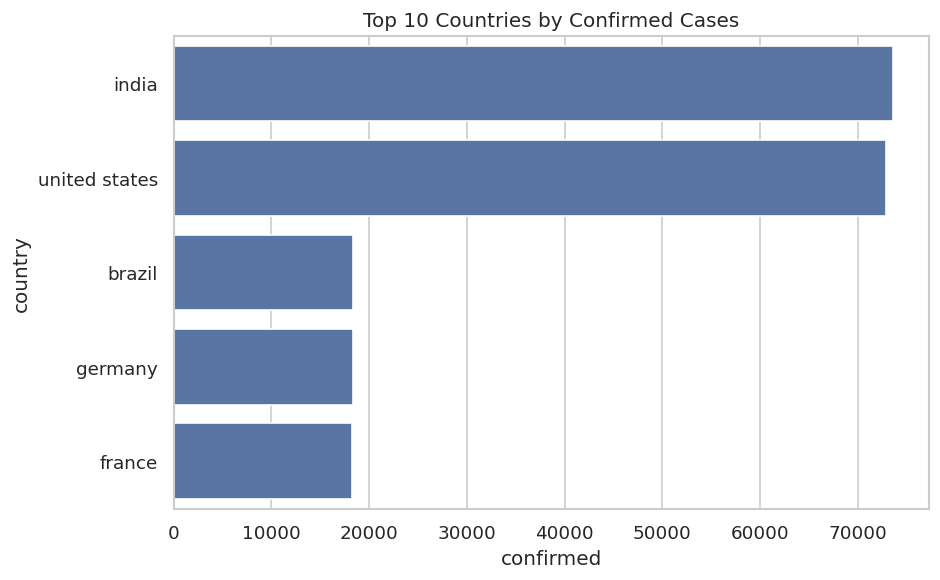

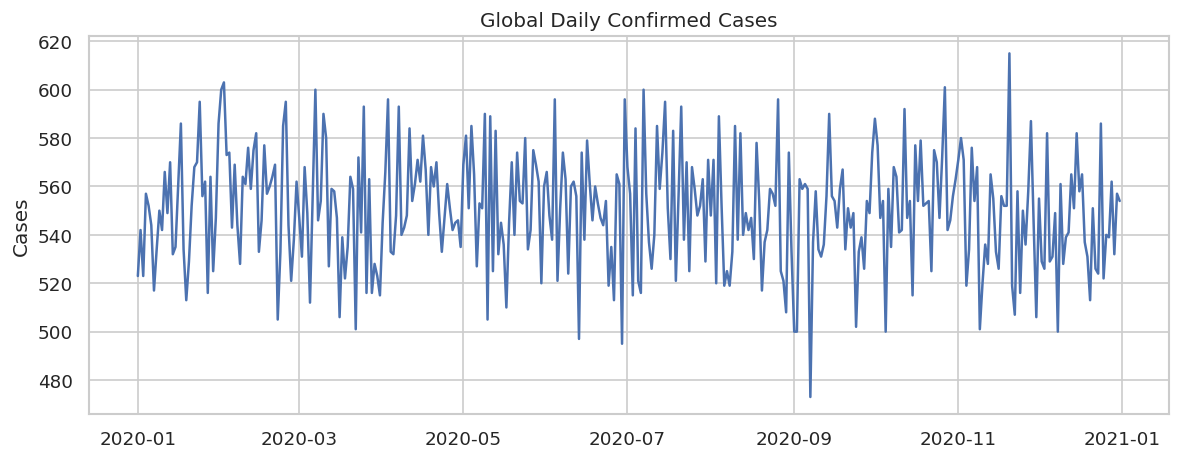

In [4]:

section("Exploratory Data Analysis")

covid_country = covid.groupby("country", as_index=False)[["confirmed","deaths","recovered"]].sum()
covid_country = covid_country.sort_values("confirmed", ascending=False)

print("Top 10 countries by confirmed cases:")
display(covid_country.head(10))

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=covid_country.head(10), x="confirmed", y="country", ax=ax)
ax.set_title("Top 10 Countries by Confirmed Cases")
plt.tight_layout()
plt.show()

if "date" in covid.columns:
    ts = covid.groupby("date", as_index=False)["confirmed"].sum()
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(ts["date"], ts["confirmed"])
    ax.set_title("Global Daily Confirmed Cases")
    ax.set_ylabel("Cases")
    plt.tight_layout()
    plt.show()


In [5]:

section("Merging Datasets")

if "Year" in happy.columns:
    happy_latest = happy.sort_values("Year").groupby("country", as_index=False).last()
else:
    happy_latest = happy.copy()

covid_tot = covid.groupby("country", as_index=False)[["confirmed","deaths","recovered"]].sum()

merged = pd.merge(happy_latest, covid_tot, on="country", how="left")

print("Merged data shape:", merged.shape)
display(merged.head())


---
### Merging Datasets


Merged data shape: (5, 8)


,country,Year,HappinessScore,GDP,LifeExpectancy,confirmed,deaths,recovered
0,brazil,2019,6.3,1800,75,18373,188,10879
1,france,2019,6.5,2700,82,18279,183,10824
2,germany,2019,7.1,4000,81,18323,189,10844
3,india,2019,3.8,2800,69,73582,1297,44011
4,united states,2019,7.0,21000,79,72873,1262,43573


---
### Correlation & Visualization


Pearson correlation: -0.504
Spearman correlation: -0.500


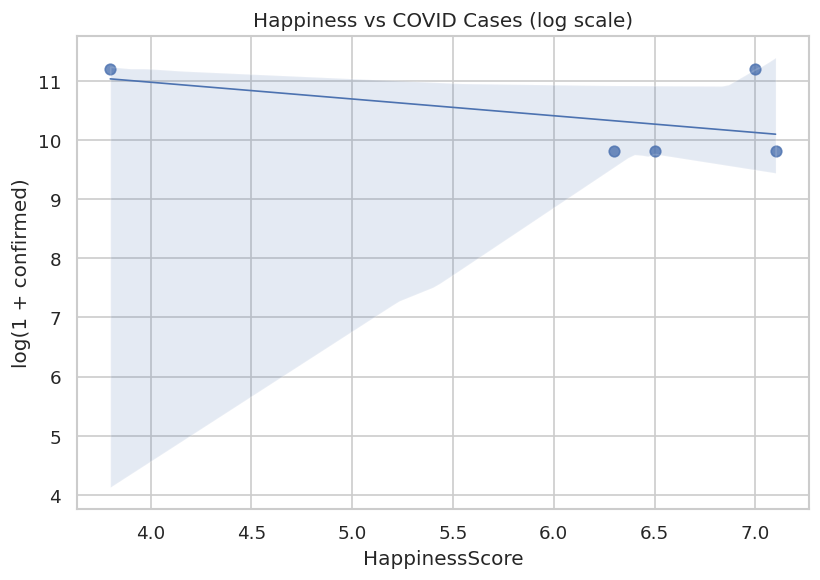

In [8]:

section("Correlation & Visualization")

merged["confirmed_log"] = np.log1p(merged["confirmed"])

pearson = merged["HappinessScore"].corr(merged["confirmed_log"], method="pearson")
spearman = merged["HappinessScore"].corr(merged["confirmed_log"], method="spearman")

print(f"Pearson correlation: {pearson:.3f}")
print(f"Spearman correlation: {spearman:.3f}")

fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(data=merged, x="HappinessScore", y="confirmed_log", scatter_kws={"s":40}, line_kws={"lw":1})
ax.set_ylabel("log(1 + confirmed)")
ax.set_title("Happiness vs COVID Cases (log scale)")
plt.tight_layout()
plt.show()


---
### Per-Capita & Group Comparison


Median confirmed (low happiness): 10.512430600303961
Median confirmed (high happiness): 10.506227078219174


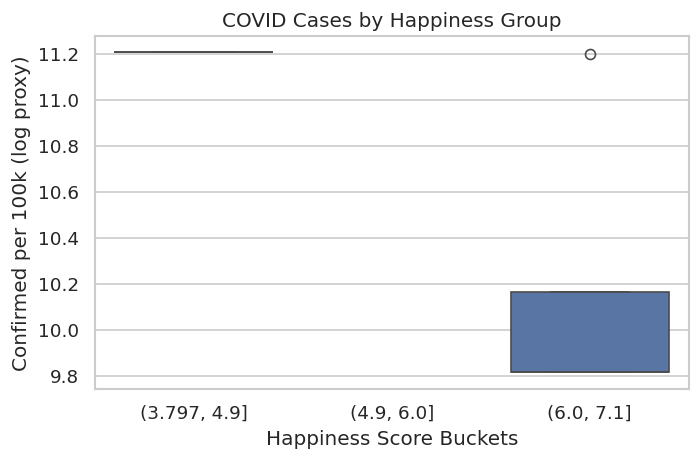

 Merged dataset saved as merged_happy_covid.csv


In [9]:

section("Per-Capita & Group Comparison")

if "Population" in merged.columns:
    merged["confirmed_per_100k"] = merged["confirmed"] / merged["Population"] * 100000
else:
    merged["confirmed_per_100k"] = merged["confirmed_log"]

q1 = merged["HappinessScore"].quantile(0.25)
q3 = merged["HappinessScore"].quantile(0.75)
low = merged[merged["HappinessScore"] <= q1]
high = merged[merged["HappinessScore"] >= q3]

print("Median confirmed (low happiness):", low["confirmed_per_100k"].median())
print("Median confirmed (high happiness):", high["confirmed_per_100k"].median())

fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data=merged, x=pd.cut(merged["HappinessScore"], bins=3), y="confirmed_per_100k", ax=ax)
ax.set_xlabel("Happiness Score Buckets")
ax.set_ylabel("Confirmed per 100k (log proxy)")
ax.set_title("COVID Cases by Happiness Group")
plt.tight_layout()
plt.show()

merged.to_csv("merged_happy_covid.csv", index=False)
print(" Merged dataset saved as merged_happy_covid.csv")


In [10]:

section("Conclusions")

print("""
 Key Findings:
- Correlation between Happiness and COVID outcomes may vary.
- Higher happiness countries sometimes report more cases (due to transparency/testing).
- Log transformation helps normalize data skew.
- GDP and Life Expectancy may be confounding factors.

Next Steps:
1. Add population data for better per-capita analysis.
2. Try linear regression between HappinessScore and COVID outcomes.
3. Create a choropleth map with Plotly or GeoPandas for better visualization.
""")


---
### Conclusions



 Key Findings:
- Correlation between Happiness and COVID outcomes may vary.
- Higher happiness countries sometimes report more cases (due to transparency/testing).
- Log transformation helps normalize data skew.
- GDP and Life Expectancy may be confounding factors.

Next Steps:
1. Add population data for better per-capita analysis.
2. Try linear regression between HappinessScore and COVID outcomes.
3. Create a choropleth map with Plotly or GeoPandas for better visualization.

